In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from osgeo import ogr, osr
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
import logging
from collections import Counter
import datetime
import os
import yaml
from sentinelhub import DataSource
import scipy.sparse as sparse
from scipy.sparse.linalg import splu


from sentinelhub import CustomUrlParam

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%run ../src/slope.py
%run ../src/utils.py

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
EPSG = CRS.WGS84
GRID_SIZE_X = 1
GRID_SIZE_Y = 1

IMAGE_X = 14*GRID_SIZE_X
IMAGE_Y = 14*GRID_SIZE_Y

TEST_X = 5
TEST_Y = 5

with open("../config.yaml", 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY = key['key']

In [4]:
year = 2018
time = (str(year - 1) +'-12-15', str(year+1) +'-1-15')
print(time)

def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):
    # LONG, LAT FOR SOME REASON
    tl = point
    
    if 48 <= tl[0] <= 54:
        epsg = 32639 if tl[1] > 0 else 32739
    if 42 <= tl[0] <= 48:
        epsg = 32638 if tl[1] > 0 else 32738
    if 36 <= tl[0] <= 42:
        epsg = 32637 if tl[1] > 0 else 32737
    if 30 <= tl[0] <= 36:
        epsg = 32636 if tl[1] > 0 else 32736
    if 24 <= tl[0] <= 30:
        epsg = 32635 if tl[1] > 0 else 32735
    if 18 <= tl[0] <= 24:
        epsg = 32634 if tl[1] > 0 else 32734

    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    #EXPANSION = (expansion - np.mean([distance1, distance2]))/2 # should this be 155 or 160?
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    #br = (br[0] + 20, br[1] + 20)
    #tl = (tl[0] - 20, tl[1] - 20)
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]
 
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

def identify_clouds(bbox, epsg = EPSG, time = time):
    try:
        box = BBox(bbox, crs = epsg)
        cloud_request = WmsRequest(
            layer='CLOUD_DETECTION',
            bbox=box,
            time=time,
            width=142,
            height=142,
            image_format = MimeType.TIFF_d32f,
            maxcc=0.5,
            instance_id=API_KEY,
            custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
            time_difference=datetime.timedelta(hours=24),
        )
        
        cloud_img = cloud_request.get_data()
        cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(cloud_img))
        means = np.mean(cloud_probs, (1, 2))
        cloud_steps = [i for i, val in enumerate(means) if val > 0.20]
        return cloud_steps, means, cloud_probs
    except Exception as e:
        logging.fatal(e, exc_info=True)
    
    
def download_dem(bbox, epsg = EPSG):
    #bbox = modify_bbox(bbox, expansion = 10)
    box = BBox(bbox, crs = epsg)
    dem_request = WmsRequest(data_source=DataSource.DEM,
                         layer='DEM',
                         bbox=box,
                         width=144,
                         height=144,
                         instance_id=API_KEY,
                         image_format=MimeType.TIFF_d32f,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})
    dem_image = dem_request.get_data()[0]
    dem_image = calcSlope(dem_image.reshape((1, 144, 144)),
                  np.full((144, 144), 10), np.full((144, 144), 10), zScale = 1, minSlope = 0.02)
    dem_image = dem_image.reshape((144,144, 1))
    dem_image = dem_image[1:143, 1:143, :]
    return dem_image #/ np.max(dem_image)


    
def download_tiles(bbox, clean_steps, epsg = EPSG, time = time):
    try:
        clean_steps = np.argwhere(clean_steps <= 0.2)
        box = BBox(bbox, crs = epsg)
        image_request = WmsRequest(
                layer='ALL_BANDS_NDVI',
                bbox=box,
                time=time,
                width=142,
                height=142,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.50,
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                time_difference=datetime.timedelta(hours=24),
            )
        img_bands = image_request.get_data()
        img_bands = np.array(img_bands)
        print("There are {}/{} clean steps".format(len(clean_steps), len(img_bands)))
        num_broken_steps = 0
        for date in range(img_bands.shape[0]):
            if date in clean_steps:
                for band in range(10):
                    uniques = [len(np.unique(img_bands[i, :, :, band])) for i in range(img_bands.shape[0])]
                    maxs = np.max(img_bands[date, :, :, band])
                    mins = np.min(img_bands[date, :, :, band])
                    if maxs >= 1.0 or mins <= 0.0:
                        num_broken_steps += 1
                        before, after = calculate_proximal_steps(uniques, date, clean_steps)
                        before = img_bands[date + int(before), :, :, band]
                        after = img_bands[date + int(after), :, :, band]
                        img_bands[date, :, :, band] = (before + after) / 2
                    if len(np.unique(img_bands[date, :, :, band])) <= 3:
                        num_broken_steps += 1
                        before, after = calculate_proximal_steps(uniques, date, clean_steps)
                        before = img_bands[date + int(before), :, :, band]
                        after = img_bands[date + int(after), :, :, band]
                        img_bands[date, :, :, band] = (before + after) / 2
        print("{} broken normal steps".format(num_broken_steps))
        return img_bands, image_request

    except Exception as e:
        logging.fatal(e, exc_info=True)
        
    
def calculate_and_save_best_images(img_bands, image_request, means, year = year):
    # Identify the date of the imagery
    image_dates = []
    for date in image_request.get_dates():
        if date.year == year - 1:
            image_dates.append(-360 + (date.month-1)*30 + date.day)
        if date.year == year:
            image_dates.append((date.month-1)*30 + date.day)
        if date.year == year + 1:
            image_dates.append(365 + (date.month-1)*30+date.day)
        #image_dates.append((date.year - 2018)*395 + date.month*30 + date.day)
    #print(image_dates)

    biweekly_dates = [day for day in range(0, 360, 15)] # ideal imagery dates are every 15 days
    
    # Identify the dates where there is < 20% cloud cover
    satisfactory_ids = list(np.argwhere(np.array(means) < 4.).reshape(-1, )) 
    satisfactory_dates = [value for idx, value in enumerate(image_dates) if idx in satisfactory_ids]
    
    
    selected_images = {}
    for i in biweekly_dates:
        distances = [abs(date - i) for date in satisfactory_dates]
        closest = np.min(distances)
        closest_id = np.argmin(distances)
        # If there is imagery within 8 days, select it
        if closest < 8:
            date = satisfactory_dates[closest_id]
            image_idx = int(np.argwhere(np.array(image_dates) == date)[0])
            selected_images[i] = {'image_date': [date], 'image_ratio': [1], 'image_idx': [image_idx]}
        # If there is not imagery within 8 days, look for the closest above and below imagery
        else:
            distances = np.array([(date - i) for date in satisfactory_dates])
            # Number of days above and below the selected date of the nearest clean imagery
            above = distances[np.where(distances < 0, distances, -np.inf).argmax()]
            below = distances[np.where(distances > 0, distances, np.inf).argmin()]
            if abs(above) > 100: # If date is the last date, occassionally argmax would set above to - number
                above = below
            if abs(below) > 100:
                below = above
            if above != below:
                below_ratio = above / (above - below)
                above_ratio = 1 - below_ratio
            else:
                above_ratio = below_ratio = 0.5
                
            # Extract the image date and imagery index for the above and below values
            above_date = i + above
            above_image_idx = int(np.argwhere(np.array(image_dates) == above_date)[0])
            
            below_date = i + below
            below_image_idx = int(np.argwhere(np.array(image_dates) == below_date)[0])
            
            selected_images[i] = {'image_date': [above_date, below_date], 'image_ratio': [above_ratio, below_ratio],
                                 'image_idx': [above_image_idx, below_image_idx]}
                            
    #for i in selected_images.keys():
    #    print(i, selected_images[i])
        
    keep_steps = []
    for i in selected_images.keys():
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
        if len(info['image_idx']) == 2:
            step1 = img_bands[info['image_idx'][0]] * info['image_ratio'][0]
            step2 = img_bands[info['image_idx'][1]] * info['image_ratio'][1]
            step = step1 + step2
        keep_steps.append(step)
        
    keep_steps = np.stack(keep_steps)
    return keep_steps

def calc_best(tiles, cloud_probs, request, offset_x, offset_y):
    c_probs = cloud_probs[:, offset_x:offset_x+16, offset_y:offset_y+16]
    images = np.stack(tiles)[:, offset_x:offset_x+16, offset_y:offset_y+16]
    args = np.array([len(np.argwhere(c_probs[x, :, :].reshape(16*16) > 0.5)) for x in range(c_probs.shape[0])])
    print(args)
    best = calculate_and_save_best_images(images, request, args)
    return best

def speyediff(N, d, format = 'csc'):
    shape = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format = format)
    return spmat

def smooth(y, lmbd, d = 2):
    m = len(y)
    E = sparse.eye(m, format = 'csc')
    D = speyediff(m, d, format = 'csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z

('2017-12-15', '2019-1-15')


In [5]:
coords = (13.540810, 38.177220) # tigray
#coords = (-1.726374, 37.440204) # makueni
#coords = (-1.515869, 29.952997) # rwanda
coords = (coords[1], coords[0])
OUTPUT_FOLDER = '../data/tigray2/'
#13.567962754335872

borders = bounding_box(coords, 10*1400, 10*1400, expansion = 0)
print(borders)

[(38.306228099454614, 13.667784864997554), (38.17721999999999, 13.540809999999999)]


In [6]:
# this needs the first coordinate to not be [coords] for different y steps

def calculate_offset_coords(coords, x_step, y_step, number):
    offset_coords = []
    y_coord = bounding_box(coords, x_step, y_step, expansion = 0)
    y_coord = y_coord[0][1]
    for i in range(number):
        bbx = bounding_box(coords, (i+1)*x_step, y_step, expansion = 10)
        coord_x = bbx[0][0]
        coord_y = y_coord
        offset_coords.append((coord_x, coord_y))
    coords = [(coords[0], y_coord)]
    return coords + offset_coords

corner_coordinates = []
for row in range(0, 20):
    temp = calculate_offset_coords(coords, x_step = 1400, 
                                            y_step = row*1400, 
                                            number = 20)
    corner_coordinates.append([[x, [y, row]] for x, y in zip(temp, [col for col in range(0, 20)])])


In [9]:
tiled_bbx = bounding_box(coords, y_offset_max = 1400, x_offset_max = 1400, expansion = 10)
cloud_steps, means, cloud_probs = identify_clouds(tiled_bbx)
#import seaborn as sns
#import matplotlib.pyplot as plt
#%matplotlib inline
#plt.figure(figsize=(10, 8))
#sns.heatmap(cloud_probs[48])

Starting: 15 0
Starting: 16 0
Starting: 17 0
Starting: 18 0
Starting: 19 0


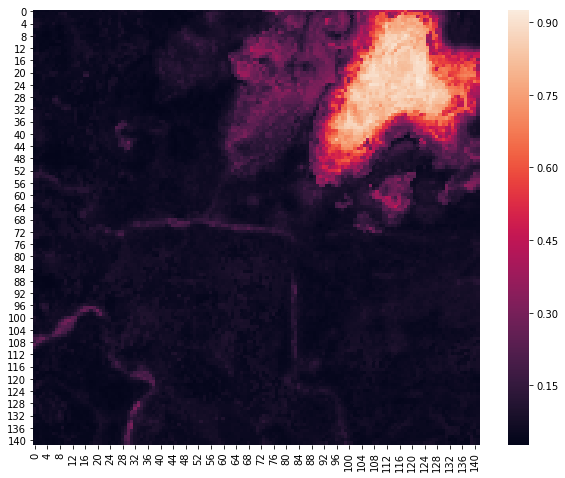

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 8))
sns.heatmap(cloud_probs[48])

In [7]:
def check_outliers(sample):
    for date in range(24):
        for band in range(10):
            maxs = np.max(sample[date, :, :, band])
            mins = np.min(sample[date, :, :, band])
            if maxs == 1.0 or mins == 0.0:
                print("Found null outlier")
                return True
            if maxs == mins:
                print("Found missing outlier")
                return True
            if maxs >= 1.05 or mins <= -1.05:
                print("Found range outlier")
                return True
    else:
        return False
    
def calculate_proximal_steps(uniques, date, clean_steps):
    arg_before = None
    arg_after = None
    uniques = np.array(uniques)
    satisfactory = np.argwhere(uniques > 2)
    satisfactory = np.array([x for x in satisfactory if x in clean_steps])
    if date > 0:
        idx_before = satisfactory - date
        arg_before = idx_before[np.where(idx_before < 0, idx_before, -np.inf).argmax()]
    if date < np.max(satisfactory):
        idx_after = satisfactory - date
        arg_after = idx_after[np.where(idx_after > 0, idx_after, np.inf).argmin()]
    if not arg_after and not arg_before:
        arg_after = date
        arg_before = date
    if not arg_after:
        arg_after = arg_before
    if not arg_before:
        arg_before = arg_after
    print(arg_before, date, arg_after)
    return arg_before, arg_after

def worker_download(coord, folder = OUTPUT_FOLDER):
    idx_x = coord[1][0]
    idx_y = coord[1][1]
    print("Starting: {} {}".format(idx_x, idx_y))
    #coord = [x[0] for x in coord]
    coord = coord[0]
    output_folder = OUTPUT_FOLDER + "{}/{}/".format(str(idx_y), str(idx_x))
    if not os.path.exists(os.path.realpath(output_folder)):
        os.makedirs(os.path.realpath(output_folder))
    tiled_bbx = bounding_box(coord, y_offset_max = 1400, x_offset_max = 1400, expansion = 10)
    dem_bbx = bounding_box(coord, y_offset_max = 1400, x_offset_max = 1400, expansion = 20)
    cloud_steps, means, cloud_probs = identify_clouds(tiled_bbx)
    tiles, request = download_tiles(tiled_bbx, means)
    dem = download_dem(dem_bbx)
    dem = np.tile(dem.reshape((1, 142, 142, 1)), (24, 1, 1, 1))
    
    for x_offset, cval in enumerate([x for x in range(0, 140, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 140, 14)]):
            # Calculate the best 24-snapshot sequence for the 16x16 tile
            x = calc_best(tiles, cloud_probs, request, cval, rval)
            # Download and extract the DEM
            dem_i = dem[:, cval:cval+16, rval:rval+16, 0]
            x = np.concatenate([x, dem_i[:, :, :, np.newaxis]], axis = -1)
            # Remove and copy blank time steps
            x = remove_blank_steps(x)
            if x.shape[1] != 16:
                print("Image size error on {} {}".format(idx_x, idx_y))
            # Check for missing bands and copy the prior timestep forward if missing
            for date in range(24):
                for band in range(10):
                    uniques = [len(np.unique(x[i, :, :, band])) for i in range(24)]
                    clean_steps = [x for x in range(0, len(uniques))]
                    maxs = np.max(x[date, :, :, band])
                    mins = np.min(x[date, :, :, band])
                    if maxs >= 1.0 or mins <= 0.0:
                        print("Found null outlier at {} {}".format(date, band))
                        before, after = calculate_proximal_steps(uniques, date, clean_steps)
                        before = x[date + int(before), :, :, band]
                        after = x[date + int(after), :, :, band]
                        x[date, :, :, band] = (before + after) / 2
                    if len(np.unique(x[date, :, :, band])) <= 3:
                        print("Found missing outlier at {} {}, {}".format(date, band, maxs))
                        before, after = calculate_proximal_steps(uniques, date, clean_steps)
                        before = x[date + int(before), :, :, band]
                        after = x[date + int(after), :, :, band]
                        x[date, :, :, band] = (before + after) / 2
            # Calculate spectral indices after dealing with missing data issues
            #x = ndvi(x, True)
            x = evi(x, True)
            #x = savi(x, True)
            x = bi(x, True)
            x = msavi2(x, True)
            x = si(x, True)
            
            # Smooth all data except slope
            x[:, :, :, 10] /= 90
            for row in range(0, 16):
                for column in range(0, 16):
                    for band in [x for x in range(0, 15) if x != 10]:
                        sm = smooth(x[:, row, column, band], 1.0, d = 2)
                        x[:, row, column, band] = sm
        
            np.save(output_folder + str(x_offset*10+y_offset+1), x)
    
    # Do the same for the corner offset imagery
    for x_offset, cval in enumerate([x for x in range(7, 133, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 133, 14)]):
            x = calc_best(tiles, cloud_probs, request, cval, rval)
            dem_i = dem[:, cval:cval+16, rval:rval+16, 0]
            x = np.concatenate([x, dem_i[:, :, :, np.newaxis]], axis = -1)
            x = remove_blank_steps(x)
            if x.shape[1] != 16:
                print("Image size error on {} {}".format(idx_x, idx_y))
            for date in range(24):
                for band in range(10):
                    maxs = np.max(x[date, :, :, band])
                    mins = np.min(x[date, :, :, band])
                    uniques = [len(np.unique(x[i, :, :, band])) for i in range(24)]
                    clean_steps = [x for x in range(0, len(uniques))]
                    if maxs >= 1.0 or mins <= 0.0:
                        print("Found null outlier at {} {}".format(date, band))
                        before, after = calculate_proximal_steps(uniques, date, clean_steps)
                        before = x[date + int(before), :, :, band]
                        after = x[date + int(after), :, :, band]
                        x[date, :, :, band] = (before + after) / 2
                    if len(np.unique(x[date, :, :, band])) <= 5:
                        print("Found missing outlier at {} {}".format(date, band))
                        before, after = calculate_proximal_steps(uniques, date, clean_steps)
                        before = x[date + int(before), :, :, band]
                        after = x[date + int(after), :, :, band]
                        x[date, :, :, band] = (before + after) / 2
            x = evi(x, True)
            x = bi(x, True)
            x = msavi2(x, True)
            x = si(x, True)
            x[:, :, :, 10] /= 90
            
            for row in range(0, 16):
                for column in range(0, 16):
                    for band in [x for x in range(0, 15) if x != 10]:
                        sm = smooth(x[:, row, column, band], 1.0, d = 2)
                        x[:, row, column, band] = sm
            np.save(output_folder + str(100+(x_offset*9+y_offset+1)), x)
    
    # Right offset
    for x_offset, cval in enumerate([x for x in range(7, 133, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 140, 14)]):
            x = calc_best(tiles, cloud_probs, request, cval, rval)
            dem_i = dem[:, cval:cval+16, rval:rval+16, 0]
            x = np.concatenate([x, dem_i[:, :, :, np.newaxis]], axis = -1)
            x = remove_blank_steps(x)
            if x.shape[1] != 16:
                print("Image size error on {} {}".format(idx_x, idx_y))
            for date in range(24):
                for band in range(10):
                    maxs = np.max(x[date, :, :, band])
                    mins = np.min(x[date, :, :, band])
                    uniques = [len(np.unique(x[i, :, :, band])) for i in range(24)]
                    clean_steps = [x for x in range(0, len(uniques))]
                    if maxs >= 1.0 or mins <= 0.0:
                        print("Found null outlier at {} {}".format(date, band))
                        before, after = calculate_proximal_steps(uniques, date, clean_steps)
                        before = x[date + int(before), :, :, band]
                        after = x[date + int(after), :, :, band]
                        x[date, :, :, band] = (before + after) / 2
                    if len(np.unique(x[date, :, :, band])) <= 5:
                        print("Found missing outlier at {} {}".format(date, band))
                        before, after = calculate_proximal_steps(uniques, date, clean_steps)
                        before = x[date + int(before), :, :, band]
                        after = x[date + int(after), :, :, band]
                        x[date, :, :, band] = (before + after) / 2
            x = evi(x, True)
            x = bi(x, True)
            x = msavi2(x, True)
            x = si(x, True)
            x[:, :, :, 10] /= 90
            
            for row in range(0, 16):
                for column in range(0, 16):
                    for band in [x for x in range(0, 15) if x != 10]:
                        sm = smooth(x[:, row, column, band], 1.0, d = 2)
                        x[:, row, column, band] = sm
            np.save(output_folder + str(100+81+(x_offset*10+y_offset+1)), x)
          
    # Up offset
    for x_offset, cval in enumerate([x for x in range(0, 140, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 133, 14)]):
            print("U: {} {}".format(x_offset, y_offset))
            x = calc_best(tiles, cloud_probs, request, cval, rval)
            dem_i = dem[:, cval:cval+16, rval:rval+16, 0]
            x = np.concatenate([x, dem_i[:, :, :, np.newaxis]], axis = -1)
            x = remove_blank_steps(x)
            if x.shape[1] != 16:
                print("Image size error on {} {}".format(idx_x, idx_y))
            for date in range(24):
                for band in range(10):
                    maxs = np.max(x[date, :, :, band])
                    mins = np.min(x[date, :, :, band])
                    uniques = [len(np.unique(x[i, :, :, band])) for i in range(24)]
                    clean_steps = [x for x in range(0, len(uniques))]
                    if maxs >= 1.0 or mins <= 0.0:
                        print("Found null outlier at {} {}".format(date, band))
                        before, after = calculate_proximal_steps(uniques, date, clean_steps)
                        before = x[date + int(before), :, :, band]
                        after = x[date + int(after), :, :, band]
                        x[date, :, :, band] = (before + after) / 2
                    if len(np.unique(x[date, :, :, band])) <= 5:
                        print("Found missing outlier at {} {}".format(date, band))
                        before, after = calculate_proximal_steps(uniques, date, clean_steps)
                        before = x[date + int(before), :, :, band]
                        after = x[date + int(after), :, :, band]
                        x[date, :, :, band] = (before + after) / 2
            #x = ndvi(x, True)
            x = evi(x, True)
            #x = savi(x, True)
            x = bi(x, True)
            x = msavi2(x, True)
            x = si(x, True)
            x[:, :, :, 10] /= 90
            
            for row in range(0, 16):
                for column in range(0, 16):
                    for band in [x for x in range(0, 15) if x != 10]:
                        sm = smooth(x[:, row, column, band], 1.0, d = 2)
                        x[:, row, column, band] = sm
            np.save(output_folder + str(100+81+90+(x_offset*9+y_offset+1)), x)
            
            

In [8]:
import logging
START_Y = 0
START_X = 0

import multiprocessing
for i in corner_coordinates[START_Y:]:
    try:
        threads = 5
        pool = multiprocessing.Pool(threads)
        zip(*pool.map(worker_download, i[START_X:]))
        pool.close()
        pool.join()
    except Exception as e:
        print("error")
        logging.fatal(e, exc_info=True)

Starting: 1 0
Starting: 0 0
Starting: 2 0
Starting: 4 0
Starting: 3 0
There are 61/74 clean steps
There are 65/74 clean steps
There are 64/74 clean steps
There are 62/74 clean steps
There are 64/74 clean steps


Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.r

Starting: 5 0
Starting: 6 0
Starting: 7 0
Starting: 8 0
Starting: 9 0


Process ForkPoolWorker-7:
Process ForkPoolWorker-9:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process ForkPoolWorker-10:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-0d360512f429>", line 10, in <module>
    zip(*pool.map(worker_download, i[START_X:]))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 266, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 635, in wait
    self._event.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 551, in wait
    signaled = self._cond.wait(timeout)
  File "/Library/Frameworks/Python.framewor

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))


KeyboardInterrupt: 

  File "<ipython-input-7-844cc4692353>", line 51, in worker_download
    cloud_steps, means, cloud_probs = identify_clouds(tiled_bbx)
  File "<ipython-input-7-844cc4692353>", line 51, in worker_download
    cloud_steps, means, cloud_probs = identify_clouds(tiled_bbx)
  File "<ipython-input-7-844cc4692353>", line 51, in worker_download
    cloud_steps, means, cloud_probs = identify_clouds(tiled_bbx)
  File "<ipython-input-7-844cc4692353>", line 51, in worker_download
    cloud_steps, means, cloud_probs = identify_clouds(tiled_bbx)
  File "<ipython-input-7-844cc4692353>", line 51, in worker_download
    cloud_steps, means, cloud_probs = identify_clouds(tiled_bbx)
  File "<ipython-input-4-77f86c5d7c6c>", line 79, in identify_clouds
    time_difference=datetime.timedelta(hours=24),
  File "<ipython-input-4-77f86c5d7c6c>", line 79, in identify_clouds
    time_difference=datetime.timedelta(hours=24),
  File "<ipython-input-4-77f86c5d7c6c>", line 79, in identify_clouds
    time_difference=dat

  File "/Users/johnbrandt/Library/Python/3.6/lib/python/site-packages/sentinelhub/ogc.py", line 518, in __next__
    self._fetch_features()
  File "/Users/johnbrandt/Library/Python/3.6/lib/python/site-packages/sentinelhub/ogc.py", line 518, in __next__
    self._fetch_features()
  File "/Users/johnbrandt/Library/Python/3.6/lib/python/site-packages/sentinelhub/ogc.py", line 518, in __next__
    self._fetch_features()
  File "/Users/johnbrandt/Library/Python/3.6/lib/python/site-packages/sentinelhub/ogc.py", line 518, in __next__
    self._fetch_features()
  File "/Users/johnbrandt/Library/Python/3.6/lib/python/site-packages/sentinelhub/ogc.py", line 550, in _fetch_features
    response = get_json(url)
  File "/Users/johnbrandt/Library/Python/3.6/lib/python/site-packages/sentinelhub/ogc.py", line 550, in _fetch_features
    response = get_json(url)
  File "/Users/johnbrandt/Library/Python/3.6/lib/python/site-packages/sentinelhub/ogc.py", line 550, in _fetch_features
    response = get_jso

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/urllib3/connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/urllib3/connectionpool.py", line 343, in _make_request
    self._validate_conn(conn)
  File "/Library/Frameworks/Python

In [13]:
for r in range(0, 10):
    for c in range(0, 10):
        worker_download(corner_coordinates[r][c])

Starting: 0 0


KeyboardInterrupt: 

In [22]:
worker_download(corner_coordinates[0][0])

Starting: 0 0
There are 64/74 clean steps
0 broken normal steps
Mean base: 8
Max base: 8
Mean base: 9
Max base: 8
Mean base: 9
Max base: 8
Mean base: 10
Max base: 8
Mean base: 10
Max base: 9
Mean base: 11
Max base: 9
Mean base: 11
Max base: 9
Mean base: 11
Max base: 9
Mean base: 10
Max base: 9
Mean base: 10
Max base: 9
Mean base: 9
Max base: 7
Mean base: 9
Max base: 8
Mean base: 9
Max base: 8
Mean base: 10
Max base: 8
Mean base: 10
Max base: 9
Mean base: 11
Max base: 9
Mean base: 11
Max base: 10
Mean base: 11
Max base: 10
Mean base: 10
Max base: 9
Mean base: 10
Max base: 9
Mean base: 9
Max base: 9


KeyboardInterrupt: 